In [5]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import tensorflow as tf
import cv2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import csv
%matplotlib inline

In [6]:
reader = csv.reader(open('german-traffic-signs/signnames.csv', 'r'))
d = {}
for row in reader:
    k, v = row
    d[k] = v
print(d)

{'ClassId': 'SignName', '0': 'Speed limit (20km/h)', '1': 'Speed limit (30km/h)', '2': 'Speed limit (50km/h)', '3': 'Speed limit (60km/h)', '4': 'Speed limit (70km/h)', '5': 'Speed limit (80km/h)', '6': 'End of speed limit (80km/h)', '7': 'Speed limit (100km/h)', '8': 'Speed limit (120km/h)', '9': 'No passing', '10': 'No passing for vechiles over 3.5 metric tons', '11': 'Right-of-way at the next intersection', '12': 'Priority road', '13': 'Yield', '14': 'Stop', '15': 'No vechiles', '16': 'Vechiles over 3.5 metric tons prohibited', '17': 'No entry', '18': 'General caution', '19': 'Dangerous curve to the left', '20': 'Dangerous curve to the right', '21': 'Double curve', '22': 'Bumpy road', '23': 'Slippery road', '24': 'Road narrows on the right', '25': 'Road work', '26': 'Traffic signals', '27': 'Pedestrians', '28': 'Children crossing', '29': 'Bicycles crossing', '30': 'Beware of ice/snow', '31': 'Wild animals crossing', '32': 'End of all speed and passing limits', '33': 'Turn right ahea

In [ ]:

np.random.seed(0)

# TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

    
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

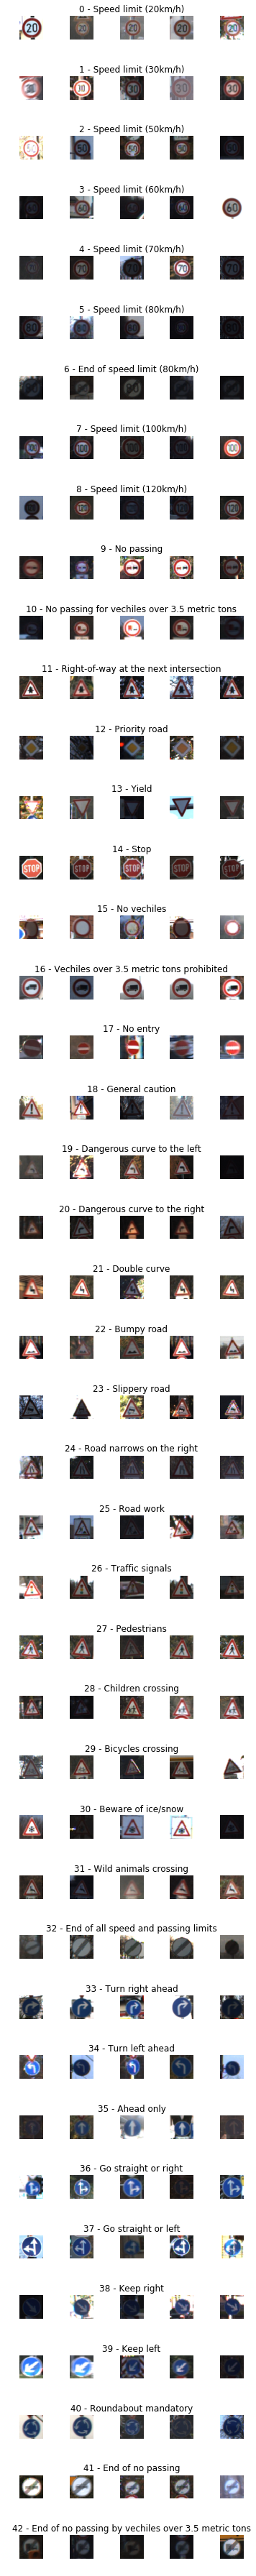

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


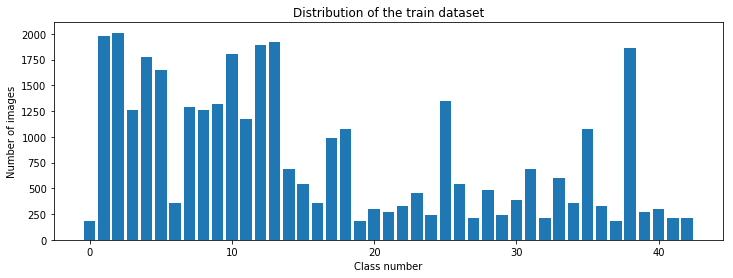

In [ ]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


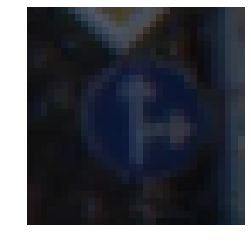

In [ ]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


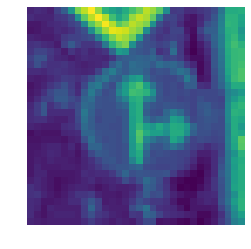

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


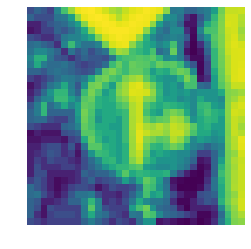

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  

(34799, 32, 32)


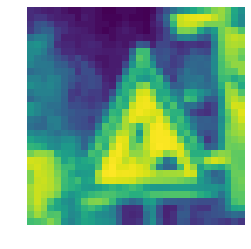

In [ ]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(15, 32, 32, 1)


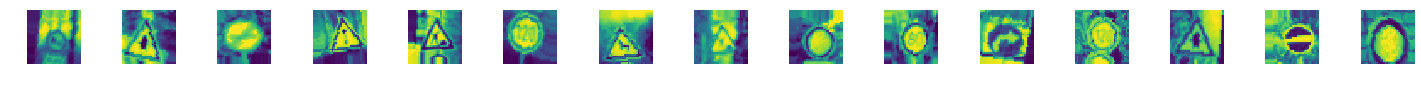

In [ ]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)


In [ ]:
def modified_model():
    
    
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

In [ ]:
# classifier = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
#                             steps_per_epoch=2000,
#                             epochs=25,
#                             validation_data=(X_val, y_val), shuffle = 1)

# model.save_weights('traffic.h5')
model.load_weights('traffic.h5')
# plt.plot(classifier.history['loss'])
# plt.plot(classifier.history['val_loss'])
# plt.title('Loss')
# plt.xlabel('epoch')
# plt.plot(classifier.history['acc'])
# plt.plot(classifier.history['val_acc'])
# plt.legend(['training','test'])
# plt.title('Accuracy')
# plt.xlabel('epoch')

In [ ]:
# classifier = model.load_weights('traffic.h5')
# plt.plot(classifier.history['loss'])
# plt.plot(classifier.history['val_loss'])
# plt.title('Loss')
# plt.xlabel('epoch')

# plt.plot(classifier.history['acc'])
# plt.plot(classifier.history['val_acc'])
# plt.legend(['training','test'])
# plt.title('Accuracy')
# plt.xlabel('epoch')

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.08591354324826415
Test accuracy: 0.976959619999687


(32, 32)
predicted sign: Speed limit (30km/h)


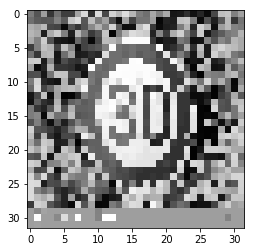

In [ ]:
import requests
from PIL import Image
# url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
# url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
# url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'
#url = 'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
# img = cv2.imread('road-sign-board-250x250.jpg')
plt.imshow(img, cmap=plt.get_cmap('gray'))
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
ktemp = model.predict_classes(img)
k = str((*ktemp))
print("predicted sign: "+ str(d[k]))